## Analisis ##
En este proyecto queremos analizar cuales suelen ser los sentimientos(positivos o negativos) en las reseñas dejadas por los usuarios.
Cada reseña cuanta con una variedad de datos, que son:

• ID: A unique ID for each row in the dataset

• ProductId: A reference to the product that the review is about

• UserId: A reference to the user who left the review

• HelpfulnessNumerator: The number of readers of the review who indicated that it was "helpful"

• HelpfulnessDenominator: The total number of people who gave an indication of whether or not the review was "helpful"

• Score: The star rating (1-5)


• Time: A Unix timestamp indicating when the review was created

• Summary: The user-written summary of what the review is about

• Text: The user-written review

## Leer y preparar los datos ##

Se lee toda la data del archivo csv que se va a procesar y se deja listo en una variable


In [33]:
import pandas as pd

data = pd.read_csv('../data/Reviews.csv',nrows=5000)

## Parte 1 ##
Para la primera parte, los registros van a ser reclasificados segun a calificacion en estrellas. las reseñas que tengan 4-5 estrellas, seran remplazadas con una calificacion 1 que sera una clasificacion positiva, las reseñas que tengan 1-2 estrellas seran remplazadas con un cero, y las reseñas que esten con una calificacion de 3 estrellas seran eliminadas.

In [34]:
import numpy as np

#modiicar la columna score
data['Score'] = np.where(data['Score'] >= 4, 1, np.where(data['Score'] <= 2, 0, data['Score']))


# Eliminar las filas donde 'Score' sea igual a 3 (si es necesario)
index_to_drop = data[data['Score'] == 3].index

# Crear un nuevo DataFrame sin las filas que cumplen la condición
data_clean = data.drop(index_to_drop)



Se cambian todas las palabras de la columna de texto a minusculas, ademas se eliminan los caracteres especiales


In [35]:
import re

#convertir todos los textos necesarios a minusculas+
data_clean['Text']=data_clean['Text'].str.lower()

# Convertir a minúsculas y eliminar caracteres especiales en las dos columnas
data_clean['Text'] = data_clean['Text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))


Se realiza la tokenizacion de palabras de la columna texto, y a su vez se eliminan los stop words

In [36]:
import nltk
from nltk.corpus import stopwords  

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


#se agrega una columna con las palabras tokenizadas
data_clean['TextTokens']=data_clean['Text'].apply(lambda x: nltk.word_tokenize(x))

#se eliminan los stopwords de los tokens
data_clean['TextTokens']= data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])



[nltk_data] Downloading package stopwords to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se eliminan las palabras mas y menos repetidas

In [37]:
from sklearn.feature_extraction.text import CountVectorizer as cv

#convertir los tokens a texto
data_clean['TextClean']=data_clean['TextTokens'].apply(lambda tokens: ' '.join(tokens) )

print(data_clean.iloc[0]['TextTokens'])
vectorizer = cv()

#se genera la matriz de frecuencia
matriz_frecuencia = vectorizer.fit_transform(data_clean['TextClean'])


#Obtener las palabras y sus frecuencias
word_freq = matriz_frecuencia.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()


# Crear un DataFrame para almacenar palabras y frecuencias
word_counts_df = pd.DataFrame({'Palabra': vocab, 'Frecuencia': word_freq})


# Obtener las palabras más y menos repetidas
palabras_mas_repetidas = word_counts_df.nlargest(15, 'Frecuencia')['Palabra'].tolist()
palabras_menos_repetidas = word_counts_df.nsmallest(15, 'Frecuencia')['Palabra'].tolist()


#eliminamos las palabras mas repetidas de los tokens
data_clean['TextTokens']=data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word not in palabras_mas_repetidas] )
data_clean['TextTokens']=data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word not in palabras_menos_repetidas] )





['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


Realizamos una nube de palabras para ver como estan los textos positivos y negativos teniendo en cuenta la calificacion de score establecida anterioremente
score = 1 (positivos)
score = 0 (negativo)

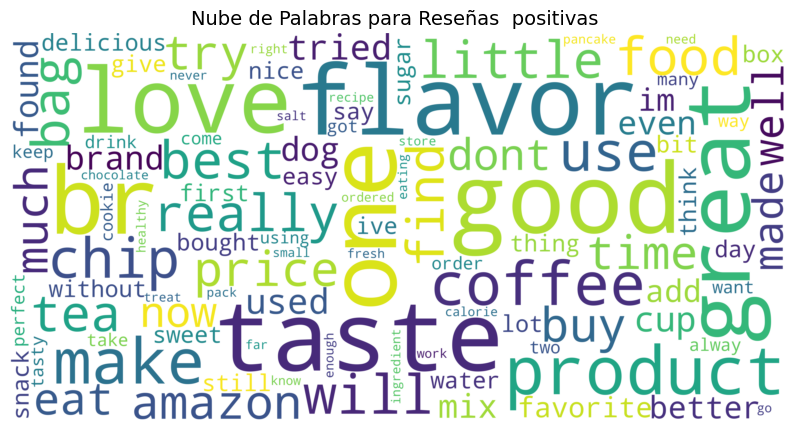

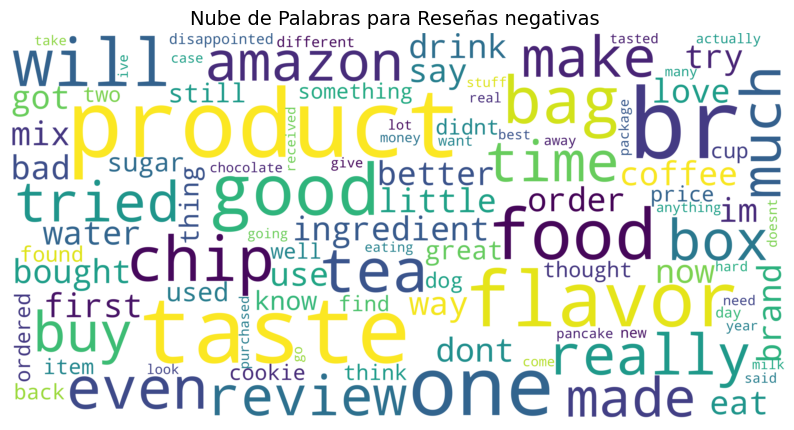

In [38]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

#unimos todos los textos de los comentarios positivos
reviews_pos=data_clean[data_clean['Score']==1]
all_reviews_pos=''.join(reviews_pos['Text'])

#unimos todos los textos de los comentarios negativos
reviews_neg=data_clean[data_clean['Score']==0]
all_reviews_neg=''.join(reviews_neg['Text'])

# Generar la nube de palabras
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale=10, width=800, height=400).generate(all_reviews_pos)
    
# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f'Nube de Palabras para Reseñas  positivas ', fontsize=14)
plt.show()


# Generar la nube de palabras
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale=10, width=800, height=400).generate(all_reviews_neg)
    
# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f'Nube de Palabras para Reseñas negativas ', fontsize=14)
plt.show()



Y por ultimo, a todos los tokens que tenemos, les eliminaremos las palabras mas y menos repetidas
